In [1]:
# #@title Install pre-requisites
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

In [2]:
# @title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess

# if subprocess.run('nvidia-smi').returncode:
#   raise RuntimeError(
#       'Cannot communicate with GPU. '
#       'Make sure you are using a GPU Colab runtime. '
#       'Go to the Runtime menu and select Choose runtime type.'
#   )

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# # Configure MuJoCo to use the EGL rendering backend (requires GPU)
# print('Setting environment variable to use GPU rendering:')
# %env MUJOCO_GL=egl

# try:
#   print('Checking that the installation succeeded:')
#   import mujoco

#   mujoco.MjModel.from_xml_string('<mujoco/>')
# except Exception as e:
#   raise e from RuntimeError(
#       'Something went wrong during installation. Check the shell output above '
#       'for more information.\n'
#       'If using a hosted Colab runtime, make sure you enable GPU acceleration '
#       'by going to the Runtime menu and selecting "Choose runtime type".'
#   )

# print('Installation successful.')

# # Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
# xla_flags = os.environ.get('XLA_FLAGS', '')
# xla_flags += ' --xla_gpu_triton_gemm_any=True'
# os.environ['XLA_FLAGS'] = xla_flags

In [3]:
# @title Import packages for plotting and creating graphics
import json
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np

# Graphics and plotting.
print("Installing mediapy:")
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


In [4]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
os.environ['MUJOCO_GL'] = 'egl'
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


In [5]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

In [6]:
# !git clone https://github.com/zeyuchang98/exo_rl_mujoco_playground.git
!cd '/content/exo_rl_mujoco_playground' && git pull
import sys
sys.path.insert(0, '/content/exo_rl_mujoco_playground')
# sys.path.insert(0, '/Users/zeyuchang/BioDynamic/mujoco_playground')

import importlib
import mujoco_playground

# # 1. Reload the actual modules from disk
# importlib.reload(mujoco_playground.config)   # Updates locomotion_params logic
# importlib.reload(mujoco_playground.wrapper)  # Updates wrapper logic
# importlib.reload(mujoco_playground.registry) # Updates registry logic

# 2. Re-run your import statements
# (This updates your local variables to point to the NEW reloaded versions)
from mujoco_playground import wrapper
from mujoco_playground import registry
from mujoco_playground.config import locomotion_params


remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 9 (delta 7), reused 9 (delta 7), pack-reused 0 (from 0)
Unpacking objects: 100% (9/9), 868 bytes | 434.00 KiB/s, done.
From https://github.com/zeyuchang98/exo_rl_mujoco_playground
   ccadfcc..d778f5c  main       -> origin/main
Updating ccadfcc..d778f5c
Fast-forward
 mujoco_playground/_src/locomotion/njit_exo/joystick.py | 6 +++---
 1 file changed, 3 insertions(+), 3 deletions(-)


In [7]:
env_name = 'NjitExoJoystickFlatTerrain'
env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)
ppo_params = locomotion_params.brax_ppo_config(env_name)
ppo_params['num_timesteps'] = int(1e8)
ppo_params['num_evals'] = 20  # Adjust evals proportionally

In [8]:
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from datetime import datetime
import numpy as np

# --- 1. Initialization ---
# Reset data containers
x_data = []
y_data = []
y_dataerr = []
times = []

# Container for ALL detailed metrics
reward_histories = defaultdict(list)

# --- CONFIGURATION: SELECT IMPORTANT REWARDS HERE ---
# Only reward names containing these strings will be plotted.
# Adjust this list to focus on what you care about.
PLOT_WHITELIST = [
    "tracking_lin_vel",  # Moving forward (The Goal)
    "alive",             # Survival signal
    "termination",       # Falling signal
    "orientation",       # Posture/Upright signal
    "dof_pos_limits",    # Joint health (Knees/Hips)
    "ang_vel_xy",        # Shaking/Stability (Optional)
]

def progress(num_steps, metrics):
    clear_output(wait=True)

    # --- 2. Store Data (Store EVERYTHING) ---
    times.append(datetime.now())
    x_data.append(num_steps)

    # Get total reward
    y_data.append(metrics.get("eval/episode_reward", 0))
    y_dataerr.append(metrics.get("eval/episode_reward_std", 0))

    # Loop through ALL metrics provided by the env
    # We save EVERYTHING to history, even if we don't plot it later
    for key, value in metrics.items():
        if 'reward' in key:
            # Clean the name: remove 'eval/' prefix
            # e.g., 'eval/episode_reward/alive' -> 'episode_reward/alive'
            # We also remove 'episode_reward/' to make the legend shorter
            clean_name = key.replace('eval/', '').replace('episode_reward/', '').replace('reward/', '')
            reward_histories[clean_name].append(value)

    # --- 3. Create Plot (Filter visual output) ---
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot Total Reward (Thick, Dark Blue Line)
    ax.errorbar(x_data, y_data, yerr=y_dataerr, color="navy", linewidth=3.0, label="TOTAL REWARD")

    # Filter: Identify which rewards to plot based on the whitelist
    rewards_to_plot = []
    for name in reward_histories.keys():
        # Check if the reward name matches any string in our whitelist
        if any(important_key in name for important_key in PLOT_WHITELIST):
            rewards_to_plot.append(name)

    # Generate distinct colors for the selected lines
    if len(rewards_to_plot) > 0:
        cmap = plt.get_cmap('tab10') # High contrast colormap
        colors = [cmap(i) for i in np.linspace(0, 1, len(rewards_to_plot))]

        # Plot loop
        for i, name in enumerate(rewards_to_plot):
            history = reward_histories[name]

            # Safety check: ensure data length matches x_data
            if len(history) == len(x_data):
                ax.plot(x_data, history, linewidth=1.5, alpha=0.8, color=colors[i], label=name)

    # --- 4. Formatting ---
    # Set X-limit to slightly past the total steps (handle default if ppo_params missing)
    total_timesteps = ppo_params.get("num_timesteps", 1e8)
    ax.set_xlim([0, total_timesteps * 1.05])

    ax.set_xlabel("# environment steps", fontsize=12)
    ax.set_ylabel("Reward Value", fontsize=12)
    ax.set_title(f"Training Progress | Step: {num_steps:.0f} | Total: {y_data[-1]:.3f}", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.4)

    # Place legend outside the plot area
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=10)

    plt.tight_layout()
    display(fig)
    plt.close(fig) # Clean up memory to avoid double plotting

In [9]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]

randomizer = mujoco_playground.registry.get_domain_randomizer(env_name)
ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    randomization_fn=randomizer,
    progress_fn=progress
)

In [1]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    eval_env=mujoco_playground.registry.load(env_name, config=env_cfg),
    wrap_env_fn=mujoco_playground.wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

import pickle
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"mujoco_policy_{timestamp}.pkl"
save_data = {
    "params": params,
    "metrics": metrics
}

with open(filename, 'wb') as f:
    pickle.dump(save_data, f)

print("download to local...")
files.download(filename)

NameError: name 'train_fn' is not defined

Loading model params from: /content/mujoco_policy_checkpoint.pkl ...
🔄 Reconstructing network structure...
🤖 Starting Rollout with command: [0.2 0.  0. ] ...
⚠️ Terminated early at step 93
✅ Rollout finished. Total steps: 93


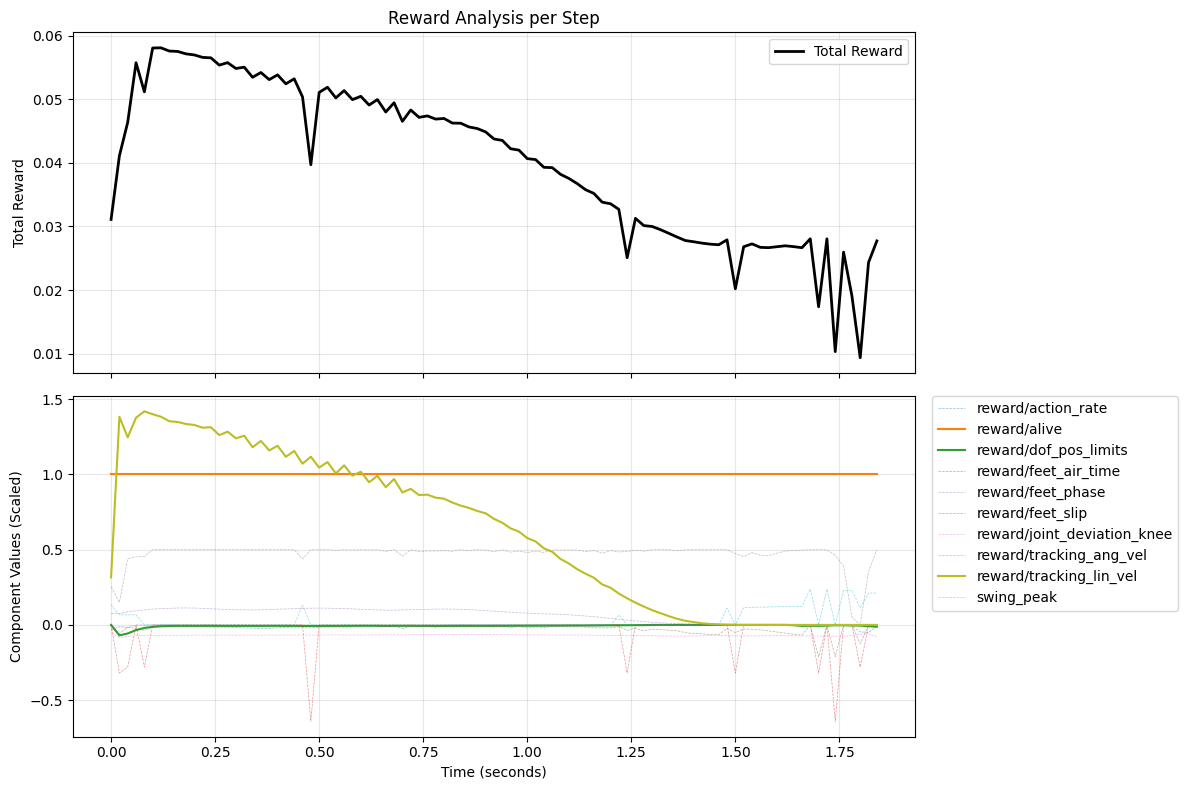

Rendering video at 50.0 FPS...


100%|██████████| 93/93 [00:02<00:00, 38.98it/s]


In [14]:
#@title Rollout, Render and Plot Rewards (With Analysis)
import matplotlib.pyplot as plt
import functools
import jax
import jax.numpy as jp
import numpy as np
import mediapy as media
from mujoco_playground._src.gait import draw_joystick_command
import pickle
# --- 1. Setup Environment ---
env = mujoco_playground.registry.load(env_name)
eval_env = mujoco_playground.registry.load(env_name)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
# Create the inference function (policy)
ckpt_path = "/content/mujoco_policy_checkpoint.pkl"

print(f"Loading model params from: {ckpt_path} ...")
with open(ckpt_path, "rb") as f:
    saved_data = pickle.load(f)

loaded_params = saved_data["params"]

print("🔄 Reconstructing network structure...")
make_inference_fn, _, _ = train_fn(
    environment=env,
    num_timesteps=0,  #step 0 for initialize
    eval_env=eval_env,
    wrap_env_fn=mujoco_playground.wrapper.wrap_for_brax_training,
)

jit_inference_fn = jax.jit(make_inference_fn(loaded_params, deterministic=True))
rng = jax.random.PRNGKey(1)

rollout = []
modify_scene_fns = []

# --- 2. Set Command (Joystick) ---
# You can modify these values to test different speeds
x_vel = 0.2  #@param {type: "number"}  # Forward velocity (m/s)
y_vel = 0.0  #@param {type: "number"}  # Lateral velocity (keep 0 for straight walking)
yaw_vel = 0.0  #@param {type: "number"} # Turning velocity
command = jp.array([x_vel, y_vel, yaw_vel])

# Phase information for gait (if used by the network)
phase_dt = 2 * jp.pi * eval_env.dt * 1.5
phase = jp.array([0, jp.pi])

print(f"🤖 Starting Rollout with command: {command} ...")

# --- 3. Run Simulation Loop ---
for j in range(1):
  state = jit_reset(rng)
  state.info["phase_dt"] = phase_dt
  state.info["phase"] = phase

  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    # Get action from the policy
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    # Step the physics environment
    state = jit_step(state, ctrl)

    if state.done:
      print(f"⚠️ Terminated early at step {i}")
      break

    # Store command info for visualization
    state.info["command"] = command
    rollout.append(state)

    # Prepare visualization data (drawing the command arrow)
    xyz = np.array(state.data.xpos[eval_env.mj_model.body("exo_pelvis").id])
    xyz += np.array([0, 0.0, 0])
    x_axis = state.data.xmat[eval_env._pelvis_body_id, 0]
    yaw = -np.arctan2(x_axis[1], x_axis[0])
    modify_scene_fns.append(
        functools.partial(
            draw_joystick_command,
            cmd=state.info["command"],
            xyz=xyz,
            theta=yaw,
            scl=np.linalg.norm(state.info["command"]),
        )
    )

print(f"✅ Rollout finished. Total steps: {len(rollout)}")

# --- 4. Plot Reward Curves (New Section) ---
# Extract data for plotting
steps = np.arange(len(rollout)) * eval_env.dt
rewards = np.array([s.reward for s in rollout])

# Try to extract individual reward components (metrics)
metrics_data = {}
if hasattr(rollout[0], 'metrics'):
    # Get all metric keys
    keys = rollout[0].metrics.keys()
    for k in keys:
        # Only extract meaningful values (ignore zero lines to keep plot clean)
        vals = np.array([s.metrics[k] for s in rollout])
        if np.abs(vals).max() > 0.01:
            metrics_data[k] = vals

# Create the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot 1: Total Reward
ax1.plot(steps, rewards, color='black', linewidth=2, label='Total Reward')
ax1.set_ylabel('Total Reward')
ax1.set_title('Reward Analysis per Step')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Key Reward Components
# Select important metrics to display to avoid clutter
key_metrics = ['tracking_lin_vel', 'alive', 'orientation', 'dof_pos_limits', 'ang_vel_xy']
for key, val in metrics_data.items():
    # Highlight key metrics with thicker lines
    if any(k in key for k in key_metrics):
        ax2.plot(steps, val, label=key, linewidth=1.5)
    else:
        ax2.plot(steps, val, label=key, linewidth=0.5, alpha=0.5, linestyle='--')

ax2.set_ylabel('Component Values (Scaled)')
ax2.set_xlabel('Time (seconds)')
ax2.grid(True, alpha=0.3)
# Place legend outside to prevent obscuring the data
ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()

# --- 5. Render Video (Safe Mode) ---
render_every = 1  # Render every 4th frame to prevent RAM OOM
fps = 1.0 / eval_env.dt / render_every
print(f"Rendering video at {fps:.1f} FPS...")

traj = rollout[::render_every]
mod_fns = modify_scene_fns[::render_every]

# Setup MuJoCo visualization options
scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True # Show visual geoms
scene_option.geomgroup[3] = False # Hide collision geoms
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True # Show contacts
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = False

# Render frames
frames = eval_env.render(
    traj,
    camera="track",
    scene_option=scene_option,
    width=640,
    height=360,
    modify_scene_fns=mod_fns,
)
# Display video
media.show_video(frames, fps=fps, loop=False)

In [12]:
reward_histories

defaultdict(list,
            {'episode_reward': [Array(1.053, dtype=float32),
              Array(2.211, dtype=float32),
              Array(2.812, dtype=float32),
              Array(3.08, dtype=float32),
              Array(3.188, dtype=float32),
              Array(3.483, dtype=float32),
              Array(3.364, dtype=float32),
              Array(3.394, dtype=float32),
              Array(3.559, dtype=float32),
              Array(4.047, dtype=float32),
              Array(3.983, dtype=float32),
              Array(4.302, dtype=float32),
              Array(4.519, dtype=float32),
              Array(4.432, dtype=float32),
              Array(4.388, dtype=float32),
              Array(5.601, dtype=float32),
              Array(5.468, dtype=float32),
              Array(4.908, dtype=float32),
              Array(5.349, dtype=float32),
              Array(5.197, dtype=float32)],
             'action_rate': [Array(-2.012, dtype=float32),
              Array(-1.628, dtype=float32),
 

In [13]:
#@title Rollout and Render
from mujoco_playground._src.gait import draw_joystick_command

env = mujoco_playground.registry.load(env_name)
eval_env = mujoco_playground.registry.load(env_name)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

rng = jax.random.PRNGKey(1)

rollout = []
modify_scene_fns = []

x_vel = 0.3
y_vel = 0.0
yaw_vel = 0.0
command = jp.array([x_vel, y_vel, yaw_vel])

phase_dt = 2 * jp.pi * eval_env.dt * 1.5
phase = jp.array([0, jp.pi])

for j in range(1):
  print(f"episode {j}")
  state = jit_reset(rng)
  state.info["phase_dt"] = phase_dt
  state.info["phase"] = phase
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = 5(state, ctrl)
    if state.done:
      break
    state.info["command"] = command
    rollout.append(state)

    xyz = np.array(state.data.xpos[eval_env.mj_model.body("exo_pelvis").id])
    xyz += np.array([0, 0.0, 0])
    x_axis = state.data.xmat[eval_env._pelvis_body_id, 0]
    yaw = -np.arctan2(x_axis[1], x_axis[0])
    modify_scene_fns.append(
        functools.partial(
            draw_joystick_command,
            cmd=state.info["command"],
            xyz=xyz,
            theta=yaw,
            scl=np.linalg.norm(state.info["command"]),
        )
    )

render_every = 1
fps = 1.0 / eval_env.dt / render_every
print(f"fps: {fps}")
traj = rollout[::render_every]
mod_fns = modify_scene_fns[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = False

frames = eval_env.render(
    traj,
    camera="track",
    scene_option=scene_option,
    width=640*2,
    height=480,
    modify_scene_fns=mod_fns,
)
media.show_video(frames, fps=fps, loop=False)

<>:31: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:31: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
/tmp/ipython-input-1147691498.py:31: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  state = 5(state, ctrl)


episode 0


TypeError: 'int' object is not callable